<a href="https://colab.research.google.com/github/skywalker0803r/Chemistry-2/blob/master/Chemistry_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;warnings.simplefilter('ignore')
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm

# helper function
def mape(y_test,y_pred): 
    mask = y_test != 0
    return (np.fabs(y_test - y_pred)/y_test)[mask].mean()

def rmse(y_test,y_pred):
    return sqrt(mean_squared_error(y_test, y_pred))

In [2]:
import os
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'Chemistry-2.png',
 'Chemistry_2.html',
 'Chemistry_2.ipynb',
 'README.md',
 '操作與品管數據(20200102提供).xlsx']

# load raw data

In [3]:
df = pd.read_excel('./操作與品管數據(20200102提供).xlsx')
df.head()

,Unnamed: 0,R141入口,Unnamed: 2,Unnamed: 3,Unnamed: 4,R141反應溫度,Unnamed: 6,Unnamed: 7,Unnamed: 8,R141出口,Unnamed: 10,品管數據,Unnamed: 12,Unnamed: 13
0,NaN,新鮮苯流量(M3/h),DIPB流量(M3/h),溫度(℃),壓力(KGf/cm2 G),第一床(℃),第二床(℃),第三床(℃),第四床(℃),溫度(℃),壓力(KGf/cm2 G),ppm,%,%
1,DATE,PHL-DCS-FIC1147_PV,PHL-DCS-FIC1149A_PV,PHL-DCS-TIC1163_PV,PHL-DCS-PI1162_PV,PHL-DCS-TI1166_PV,PHL-DCS-TI1167_PV,PHL-DCS-TI1168_PV,PHL-DCS-TI1169_PV,PHL-DCS-TI1170_PV,PHL-DCS-PIC1166_PV,T121 EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
2,2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
3,2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
4,2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137


# table data

In [4]:
cols = ['Date','R141入口_新鮮苯流量','R141入口_DIPB流量','R141入口_溫度','R141入口_壓力',
        'R141反應溫度_第一床','R141反應溫度_第二床','R141反應溫度_第三床','R141反應溫度_第四床',
        'R141出口_溫度','R141出口_壓力','T121_EB含量','DIPB轉化率(檢測)','DIPB轉化率(計算)']
values = df.iloc[2:,:]
new_df = pd.DataFrame(values.values,columns=cols)
new_df = new_df.set_index('Date')
print(new_df.shape)
new_df.head()

(83027, 13)


,R141入口_新鮮苯流量,R141入口_DIPB流量,R141入口_溫度,R141入口_壓力,R141反應溫度_第一床,R141反應溫度_第二床,R141反應溫度_第三床,R141反應溫度_第四床,R141出口_溫度,R141出口_壓力,T121_EB含量,DIPB轉化率(檢測),DIPB轉化率(計算)
Date,,,,,,,,,,,,,
2013-08-20 10:10:00,31.212,24.9928,169.894,[-11059] No Good Data For Calculation,167.057,166.569,166.279,165.041,[-11059] No Good Data For Calculation,12.297,NaN,NaN,58.7768
2013-08-20 10:20:00,31.2236,25.0668,169.753,[-11059] No Good Data For Calculation,167.051,166.576,166.26,164.97,[-11059] No Good Data For Calculation,12.2914,NaN,NaN,58.8524
2013-08-20 10:30:00,31.5726,25.163,169.526,[-11059] No Good Data For Calculation,167.042,166.584,166.235,164.877,[-11059] No Good Data For Calculation,12.3175,NaN,NaN,59.1137
2013-08-20 10:40:00,31.8862,25.1367,169.317,[-11059] No Good Data For Calculation,167.034,166.592,166.21,164.784,[-11059] No Good Data For Calculation,12.3179,NaN,NaN,58.8904
2013-08-20 10:50:00,31.8554,25.2207,169.665,[-11059] No Good Data For Calculation,167.026,166.6,166.186,164.691,[-11059] No Good Data For Calculation,12.3155,NaN,NaN,58.7622


# col transform

In [5]:
new_df = new_df.replace('[-11059] No Good Data For Calculation',np.nan)

In [6]:
for i in new_df.columns.tolist():
    new_df[i] = pd.to_numeric(new_df[i])
new_df.dtypes

R141入口_新鮮苯流量     float64
R141入口_DIPB流量    float64
R141入口_溫度        float64
R141入口_壓力        float64
R141反應溫度_第一床     float64
R141反應溫度_第二床     float64
R141反應溫度_第三床     float64
R141反應溫度_第四床     float64
R141出口_溫度        float64
R141出口_壓力        float64
T121_EB含量        float64
DIPB轉化率(檢測)      float64
DIPB轉化率(計算)      float64
dtype: object

In [7]:
df = new_df
del new_df

# DATA CLEAN

In [8]:
def data_filter(df):
    df = df.drop('DIPB轉化率(檢測)',axis=1)
    df = df.dropna(subset=['DIPB轉化率(計算)'])
    df = df[df['DIPB轉化率(計算)']>0]
    return df

print(df.shape)
df = data_filter(df)
print(df.shape)

(83027, 13)
(76552, 12)


# miss value check

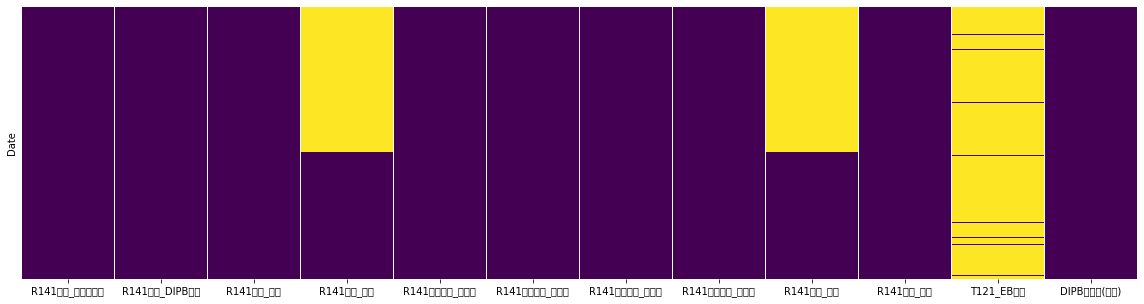

In [9]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [10]:
df[df['T121_EB含量'].isnull()==False][['T121_EB含量']]

,T121_EB含量
Date,
2013-08-20 16:00:00,112.0
2013-08-21 00:00:00,85.0
2013-08-21 08:00:00,109.0
2013-08-21 16:00:00,109.0
2013-08-22 00:00:00,102.0
...,...
2015-03-18 08:00:00,83.0
2015-03-18 16:00:00,84.0
2015-03-19 00:00:00,84.0


In [11]:
mt = pd.DataFrame(df.isnull().sum(),columns=['total'])
mt['%'] = (mt['total']/len(df))*100
mt.style.background_gradient()

,total,%
R141入口_新鮮苯流量,0,0
R141入口_DIPB流量,0,0
R141入口_溫度,0,0
R141入口_壓力,40946,53.4878
R141反應溫度_第一床,0,0
R141反應溫度_第二床,0,0
R141反應溫度_第三床,0,0
R141反應溫度_第四床,0,0
R141出口_溫度,40945,53.4865
R141出口_壓力,0,0


# fill miss value

In [12]:
x_col = df.drop(['DIPB轉化率(計算)'],axis=1).columns.tolist()
x_col

['R141入口_新鮮苯流量',
 'R141入口_DIPB流量',
 'R141入口_溫度',
 'R141入口_壓力',
 'R141反應溫度_第一床',
 'R141反應溫度_第二床',
 'R141反應溫度_第三床',
 'R141反應溫度_第四床',
 'R141出口_溫度',
 'R141出口_壓力',
 'T121_EB含量']

# KNNImputer

In [13]:
df = shuffle(df)
step = 3000
for i in tqdm(range(0, len(df), step)):
    start, end = i, min(i+step,len(df))
    imputer = KNNImputer(n_neighbors = 3)
    df.iloc[start:end][x_col] = imputer.fit_transform(df.iloc[start:end][x_col])
df = df.sort_index()

# mean Imputer

In [14]:
#for i in tqdm(df.columns):
#    df[i] = df[i].fillna(df[i].mean())

# median Imputer

In [15]:
#for i in tqdm(df.columns):
#    df[i] = df[i].fillna(df[i].median())

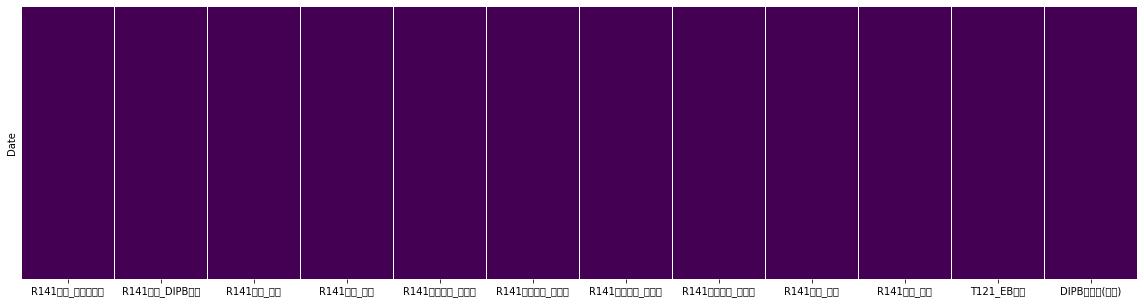

In [16]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# describe

In [17]:
df.iloc[:,-2:].describe().apply(lambda x:round(x,2))

,T121_EB含量,DIPB轉化率(計算)
count,76552.00,76552.00
mean,95.76,58.87
std,16.02,4.00
min,8.00,9.86
25%,83.67,57.34
50%,94.67,58.42
75%,102.67,59.74
max,283.00,290.24


# EDA

In [18]:
#import seaborn as sns
#sns.distplot(df['DIPB轉化率(計算)'].dropna().values)

In [19]:
#import matplotlib.pyplot as plt

#y_name = 'DIPB轉化率(計算)'
#for i in df.columns.tolist()[1:]:
#  print(i)
#  plt.scatter(df[i],df[y_name])
#  plt.show()

In [20]:
#df.corr().style.background_gradient()

# features engineering

In [21]:
pass

# feature select

In [22]:
features = df.drop(['DIPB轉化率(計算)'],axis=1).columns.tolist()
y_name = 'DIPB轉化率(計算)'

df = df[features+[y_name]].dropna(subset=[y_name])

X = df[features]
y = df[y_name]

print(X.shape,y.shape)

(76552, 11) (76552,)


# split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

model = Pipeline(steps=[
                        ('scaler',StandardScaler()),
                        ('reg',XGBRegressor(objective='reg:squarederror')),
                        ])

# train and predict

In [25]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# metric

In [26]:
FIMP = pd.DataFrame(model['reg'].feature_importances_,index=X.columns,columns=['imp'])
FIMP = FIMP.sort_values(by='imp',ascending=False)
FIMP.style.background_gradient()

,imp
R141出口_壓力,0.403203
R141入口_新鮮苯流量,0.20805
R141入口_壓力,0.084343
R141入口_DIPB流量,0.0727618
R141反應溫度_第二床,0.0584534
R141出口_溫度,0.0425934
R141反應溫度_第三床,0.0382845
R141反應溫度_第一床,0.0332921
T121_EB含量,0.0252415
R141入口_溫度,0.0231745


In [27]:
y_pred = pd.Series(y_pred,index=y_test.index,name='y_pred')

Text(0.5, 1.0, 'Moving average 6*24(day)')

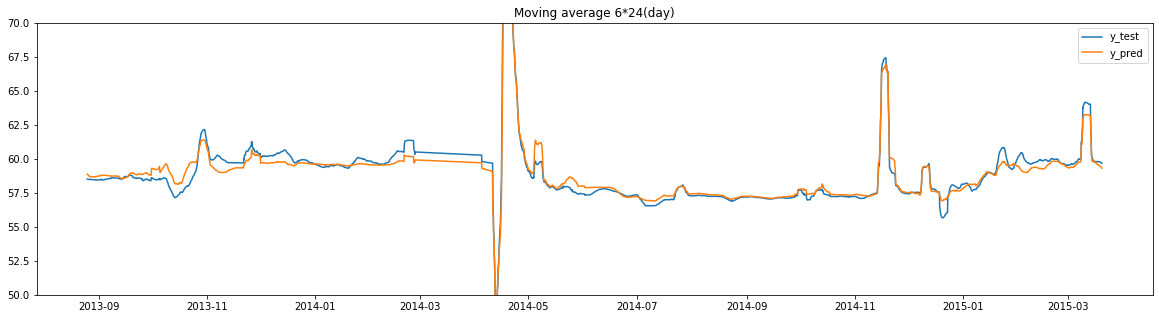

In [28]:
fig = plt.figure(figsize=(20,5))
plt.plot(y_test.sort_index().rolling(6*24).mean(),label='y_test')
plt.plot(y_pred.sort_index().rolling(6*24).mean(),label='y_pred')
plt.ylim(50,70)
plt.legend()
plt.title('Moving average 6*24(day)')

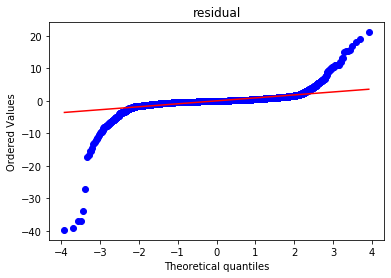

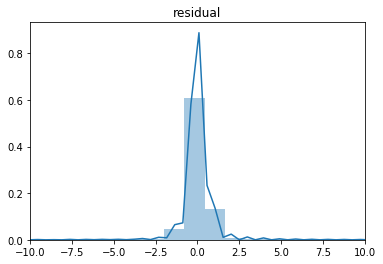

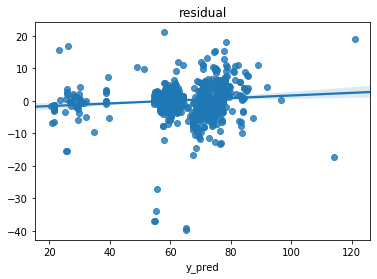

In [29]:
from scipy import stats

residual = y_test - y_pred

# plot1
stats.probplot(residual, plot=plt)
plt.title('residual')
plt.show()

# plot2
sns.distplot(residual)
plt.xlim(-10,10)
plt.title('residual')
plt.show()

# plot3
sns.regplot(y_pred,residual)
plt.title('residual')
plt.show()

# evaluate

In [30]:
t = pd.DataFrame(index=['knn_filled'],columns=['r2','rmse','mape'])
t['r2'] = r2_score(y_test,y_pred)
t['rmse'] = rmse(y_test,y_pred)
t['mape'] = mape(y_test,y_pred)
t

,r2,rmse,mape
knn_filled,0.881019,1.341809,0.009571
